In [1]:
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import csr_matrix, issparse


# **Assignment 2: 3D Reconstruction Using Stereo Disparity**

In this assignment, you will learn about 3D reconstruction using stereo vision. You’ll perform stereo rectification, stereo matching, disparity calculation, and 3D point cloud generation. Each section contains theoretical background and code outlines with function placeholders, along with hints on OpenCV functions to use.

I am uploading three datasets:

1. Bike
2. Umbrella
3. Cycle

These datasets are taken from [Middlebury](https://vision.middlebury.edu/stereo/data/scenes2014/) and contain the left and right images along with the calibration information.

---

## **Calibration File Format**

Here is a sample `calib.txt` file for one of the full-size training image pairs:

```
cam0=[3997.684 0 1176.728; 0 3997.684 1011.728; 0 0 1]
cam1=[3997.684 0 1307.839; 0 3997.684 1011.728; 0 0 1]
doffs=131.111
baseline=193.001
width=2964
height=1988
ndisp=280
isint=0
vmin=31
vmax=257
dyavg=0.918
dymax=1.516
```

### **Explanation**
- **cam0, cam1**: Camera matrices for the rectified views, in the form `[f 0 cx; 0 f cy; 0 0 1]` where:
  - `f`: focal length in pixels
  - `cx, cy`: principal point coordinates (note that `cx` differs between view 0 and 1)
- **doffs**: x-difference of principal points, `doffs = cx1 - cx0`
- **baseline**: Camera baseline in mm
- **width, height**: Image dimensions
- **ndisp**: Upper bound on disparity levels
- **isint**: Whether ground-truth disparities are integer-valued
- **vmin, vmax**: Minimum and maximum disparities for visualization
- **dyavg, dymax**: Indicators of calibration error

---

## **Submission Guide**

Submit the following:

- A well-commented codebase demonstrating each step of the reconstruction process, with explanations of each implementation step, results of each step, and visualizations of the 3D point cloud. You are allowed to use built-in functions from OpenCV, but you must check the official documentation for any function you use and include an explanation of how it works in your implementation.
- Create a zip folder with your last name and send the assignment to me via Teams messages.

**Submission deadline**: 05/02/2025 @ 23:59

---

In [2]:
import numpy as np

def read_calibration(calib_file):
    """Reads calibration data from a file.

    This function parses a calibration file where each line defines a 
    calibration parameter in the format "key=value" or "key=[matrix_rows]".
    Matrices are represented as semicolon-separated rows, with space-separated
    elements within each row (e.g., "K=[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]").

    Args:
        calib_file: Path to the calibration file.

    Returns:
        A dictionary where keys are the calibration parameter names and 
        values are either floats, strings, or NumPy arrays (for matrices).
        Returns an empty dictionary if the file does not exist or if there is an error while reading.
    """
    calib_data = {}
    try:
        with open(calib_file, 'r') as f:
            for line in f:
                line = line.strip()  # Remove leading/trailing whitespace
                if not line or line.startswith('#'):  # Skip empty lines and comments
                    continue

                try:
                    key, value = line.split('=', 1) # Split only once
                    key = key.strip() # Remove whitespace from key
                    value = value.strip() # Remove whitespace from value

                    # Attempt to parse as a matrix
                    if value.startswith('['): # Check if it is a matrix
                        matrix_rows = value.strip('[]').split(';')
                        matrix = []
                        for row in matrix_rows:
                            try: #Handle cases where the matrix might not be complete
                                matrix.append([float(x) for x in row.strip().split()])
                            except ValueError as e:
                                print(f"Warning: Error parsing matrix row: {row}. Skipping this row. Error: {e}")
                                continue #Skip to the next row if there is an error
                        calib_data[key] = np.array(matrix)
                    else:
                        try:
                            calib_data[key] = float(value)
                        except ValueError:
                            calib_data[key] = value
                except ValueError as e:
                    print(f"Warning: Error parsing line: {line}. Skipping. Error: {e}")
                    continue #Skip to the next line if there is an error

    except FileNotFoundError:
        print(f"Error: Calibration file not found: {calib_file}")
        return {} # Return empty if file is not found
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return {}

    return calib_data

## **Objective**

### **Section 1: Stereo Rectification**

#### **Theory**
Stereo rectification ensures that corresponding points in the two images lie on the same scanline, simplifying disparity calculation. 

#### **Code Outline and Hints**
```python
import cv2

def stereo_rectify(K0, K1, R, T, image_size):
    """
    Perform stereo rectification.
    :param K0: Intrinsic matrix of left camera
    :param K1: Intrinsic matrix of right camera
    :param R: Rotation matrix between the cameras
    :param T: Translation vector between the cameras
    :param image_size: Tuple (width, height)
    :return: Rectification maps
    """
    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(K0, K1, None, None, image_size, R, T)
    return R1, R2, P1, P2, Q
```

- **Functions to Explore**: `cv2.stereoRectify`

---

In [3]:
def stereo_rectify(K0, K1, R, T, image_size):
    """Performs stereo rectification.

    This function takes the camera intrinsic parameters (K0, K1), rotation (R), 
    translation (T) between the two cameras, and the image size, and returns 
    the rectification transformations (R1, R2, P1, P2) and the disparity-to-depth 
    mapping matrix (Q).  It uses OpenCV's stereoRectify function.

    Args:
        K0: Camera intrinsic matrix for the left camera (3x3 numpy array).
        K1: Camera intrinsic matrix for the right camera (3x3 numpy array).
        R: Rotation matrix between the two cameras (3x3 numpy array).
        T: Translation vector between the two cameras (3x1 or 1x3 numpy array).
        image_size: Size of the image (tuple or list of (width, height)).

    Returns:
        R1: Rectification rotation matrix for the left camera (3x3 numpy array).
        R2: Rectification rotation matrix for the right camera (3x3 numpy array).
        P1: Projection matrix for the left camera after rectification (3x4 numpy array).
        P2: Projection matrix for the right camera after rectification (3x4 numpy array).
        Q: Disparity-to-depth mapping matrix (4x4 numpy array).
    """
    T = T.astype(np.float64)  # Ensure T is float64 for cv2.stereoRectify

    R1, R2, P1, P2, Q = cv2.stereoRectify(K0, None, K1, None, image_size, R, T)
    return R1, R2, P1, P2, Q

### **Section 2: Stereo Matching and Disparity Map Calculation**

#### **Theory**
Stereo matching computes disparity by finding corresponding pixels between left and right images. Depth $Z$ is derived as:
$$
Z = \frac{f \cdot B}{d}
$$
where $f$ is the focal length, $B$ is the baseline, and $d$ is the disparity.

#### **Code Outline and Hints**
```python
import numpy as np

def compute_disparity_map(imgL, imgR):
    """
    Compute disparity map from stereo images.
    """
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=16*16,
        blockSize=15,
        P1=8*3*15**2,
        P2=32*3*15**2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32
    )
    disparity_map = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    return disparity_map
```

- **Functions to Explore**: `cv2.StereoBM_create`, `cv2.StereoSGBM_create`

---

In [4]:
def compute_disparity_map(imgL, imgR, ndisp, mindis):
    """
    Compute disparity map from stereo images.

    Parameters:
    - imgL (numpy.ndarray): Left image as a grayscale numpy array.
    - imgR (numpy.ndarray): Right image as a grayscale numpy array.
    - ndisp (int): Upper bound on disparity levels.
    - mindis (int): Minimum disparity value.
    Returns:
    - disparity_map (numpy.ndarray): Disparity map as a float32 numpy array.

    This function uses the StereoSGBM algorithm to compute the disparity map from the left and right images.
    The disparity map is a 2D array where each pixel value represents the disparity between the corresponding points in the left and right images.
    The disparity map is computed using the StereoSGBM algorithm, which is a block-matching algorithm that estimates the disparity by finding the
    best match for each block of pixels in the left image in the right image. The algorithm uses a cost function to measure the similarity between
    the blocks and selects the block with the lowest cost as the best match. The disparity map is then computed by dividing the difference in pixel
    positions between the left and right images by the baseline.

    The function takes as input the left and right images as grayscale numpy arrays, as well as the upper bound on disparity levels (ndisp) and
    the minimum disparity value (mindis). The function returns the disparity map as a float32 numpy array.
    """
    # Using StereoSGBM for better results (more parameters to tune)
    stereo = cv2.StereoSGBM_create(
        minDisparity=mindis,
        numDisparities=ndisp,
        blockSize=11,  # You can experiment with this value (odd numbers: 3, 5, 7, ...)
        P1=8 * 3 * 11**2,  # Adjusted parameters (proportional to blockSize)
        P2=32 * 3 * 11**2,  # Adjusted parameters (proportional to blockSize)
        disp12MaxDiff=1,
        preFilterCap=63,  # add this parameter
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
    )

    disparity_map = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    mask = disparity_map > 0  # Example: keep only positive disparities
    disparity_map = disparity_map * mask.astype(np.float32)
    return disparity_map

### **Section 3: 3D Reconstruction**

#### **Theory**
The disparity map enables 3D reconstruction by computing $(X, Y, Z)$ coordinates for each pixel:
$$
X = \frac{(u - c_x) \cdot Z}{f_x}, \quad Y = \frac{(v - c_y) \cdot Z}{f_y}, \quad Z = \frac{f \cdot B}{d}
$$
where $(u, v)$ is the pixel position, and $(c_x, c_y)$ are principal points.

#### **Code Outline and Hints**
```python
import cv2
import numpy as np

def reconstruct_3D(disparity_map, Q):
    """
    Reconstruct 3D points from disparity map.
    """
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
    return points_3D
```

- **Functions to Explore**: `cv2.reprojectImageTo3D`

---

In [5]:
def reconstruct_3D(disparity_map: np.ndarray, Q: np.ndarray) -> np.ndarray:
    """Reconstructs 3D points from a disparity map using a Q matrix.

    This function takes a disparity map and a Q (disparity-to-depth) matrix 
    and uses OpenCV's `cv2.reprojectImageTo3D` to reconstruct a 3D point cloud.

    Args:
        disparity_map: The disparity map (NumPy array, usually float32).
        Q: The disparity-to-depth mapping matrix (4x4 NumPy array).

    Returns:
        A 3D point cloud (NumPy array).  The shape of the returned array 
        is (height, width, 3), where each element [y, x, :] represents the 
        3D coordinates (x, y, z) of the point corresponding to pixel (x, y) 
        in the disparity map.  Returns None if there is an error.
    """
    try:
        points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
        return points_3D
    except Exception as e:
        print(f"Error in reconstruct_3D: {e}")
        return None


### **Section 4: Visualization**

#### **Theory**
To verify reconstruction, visualize the 3D points using Open3D.

#### **Code Outline and Hints**
```python
import open3d as o3d

def visualize_point_cloud(points_3D, colors):
    """
    Visualize the 3D point cloud.
    """
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points_3D.reshape(-1, 3))
    point_cloud.colors = o3d.utility.Vector3dVector(colors.reshape(-1, 3) / 255.0)
    o3d.visualization.draw_geometries([point_cloud])
```

- **Functions to Explore**: `o3d.geometry.PointCloud`, `o3d.visualization.draw_geometries`

---

## **References**
- [OpenCV Depth Map Tutorial](https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/page_tutorial_py_depthmap.html)

In [6]:
import open3d as o3d
import numpy as np

def visualize_point_cloud(points_3D: np.ndarray, colors: np.ndarray, disparity_map: np.ndarray):
    """Visualizes the 3D point cloud using Open3D.

    This function takes 3D points, colors, and a disparity map, filters out 
    invalid points (NaN, infinite, or where disparity is zero or negative), 
    and visualizes the point cloud using Open3D.

    Args:
        points_3D: 3D point cloud (NumPy array of shape (H, W, 3)).
        colors: Color information for each point (NumPy array of shape (H, W, 3) or (N, 3)).
        disparity_map: Disparity map (NumPy array of shape (H, W)).
    """
    try:
        # Mask invalid points (NaN, infinite, or where disparity is <= 0)
        mask = ~np.isnan(points_3D[:, :, 0]) & ~np.isinf(points_3D[:, :, 0]) & (disparity_map > 0)

        if not np.any(mask): #Check if there are any valid points before proceeding
            print("Warning: No valid points to visualize after masking.")
            return #Exit early if there are no valid points

        valid_points = points_3D[mask]
        valid_colors = colors[mask]


        point_cloud = o3d.geometry.PointCloud()
        point_cloud.points = o3d.utility.Vector3dVector(valid_points) #No need to reshape now
        point_cloud.colors = o3d.utility.Vector3dVector(valid_colors / 255.0)  # Normalize colors

        o3d.visualization.draw_geometries([point_cloud])

    except Exception as e:
        print(f"Error in visualize_point_cloud: {e}")

The codebase is mature enough to run on all datasets. Just change the dataset name and images name in below.

In [15]:

# Example usage (replace with your actual paths)
dataset_name = "bike" # "Bike" or "Umbrella" or "Cycle"
left_image_path = f"{dataset_name}/im0.png"
right_image_path = f"{dataset_name}/im1.png"
calibration_file_path = f"{dataset_name}/calibration_info.txt"

# 1. Read Calibration Data
calib_data = read_calibration(calibration_file_path)
baseline = calib_data['baseline']
K0 = np.array(calib_data['cam0'])
K1 = np.array(calib_data['cam1'])
R = np.eye(3)  # Identity matrix (no rotation)
T = np.array([baseline, [0], [0]])  # Baseline of 193.001 mm along the x-axis
image_size = (int(calib_data['width']), int(calib_data['height']))
ndisp = int(calib_data['ndisp'])
mindist = int(calib_data['vmin'])

/tmp/ipykernel_332914/2225368991.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  T = np.array([baseline, [0], [0]])  # Baseline of 193.001 mm along the x-axis


In [16]:
# Stereo rectification using assumed R and T (no rotation, baseline translation)
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
    K0, None, K1, None, image_size, R, T, alpha=0
)

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'stereoRectify'
> Overload resolution failed:
>  - T data type = object is not supported
>  - Expected Ptr<cv::UMat> for argument 'T'


In [122]:
# 2. Read Images
imgL = cv2.imread(left_image_path, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(right_image_path, cv2.IMREAD_GRAYSCALE)
imgL_color = cv2.imread(left_image_path) # For color visualization

In [12]:
# 4. Rectify Images
mapL1, mapL2 = cv2.initUndistortRectifyMap(K0, None, R1, P1, image_size, cv2.CV_32FC1)
mapR1, mapR2 = cv2.initUndistortRectifyMap(K1, None, R2, P2, image_size, cv2.CV_32FC1)

imgL_rect = cv2.remap(imgL, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)
imgR_rect = cv2.remap(imgR, mapR1, mapR2, interpolation=cv2.INTER_LINEAR)
imgL_rect_color = cv2.remap(imgL_color, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)

# 5. Disparity Calculation
disparity_map = compute_disparity_map(imgL, imgR, ndisp, mindist)

plt.figure(figsize=(10,5))
plt.imshow(disparity_map, cmap='jet')
plt.title("Disparity Map")
plt.colorbar()
plt.show()

# 6. 3D Reconstruction
points_3D = reconstruct_3D(disparity_map, Q)
# 7. Visualization
visualize_point_cloud(points_3D, cv2.cvtColor(imgL_color, cv2.COLOR_BGR2RGB), disparity_map)

#Optional: Save the point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3D.reshape(-1, 3))
o3d.io.write_point_cloud(f"{dataset_name}_point_cloud.ply", pcd)

NameError: name 'R1' is not defined

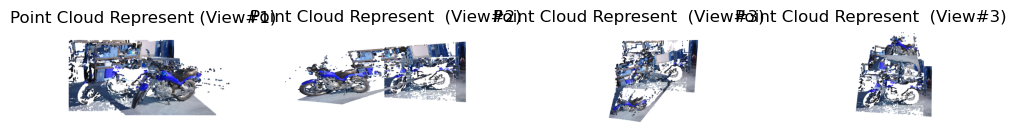

In [ ]:
# Point cloud screenshot

view1 = cv2.imread('/home/ahmad/Documents/ahmad/MyFolder_other_stuff/Educational/Vibot/M1/CV_fofi/Assignmnet 2 Dense 3D reconstruction/Screenshot from 2025-02-05 23-54-56.png')
view2 = cv2.imread('/home/ahmad/Documents/ahmad/MyFolder_other_stuff/Educational/Vibot/M1/CV_fofi/Assignmnet 2 Dense 3D reconstruction/Screenshot from 2025-02-05 23-55-14.png')
view3 = cv2.imread('/home/ahmad/Documents/ahmad/MyFolder_other_stuff/Educational/Vibot/M1/CV_fofi/Assignmnet 2 Dense 3D reconstruction/Screenshot from 2025-02-05 23-55-33.png')
view4 = cv2.imread('/home/ahmad/Documents/ahmad/MyFolder_other_stuff/Educational/Vibot/M1/CV_fofi/Assignmnet 2 Dense 3D reconstruction/Screenshot from 2025-02-05 23-55-46.png')


title = "Point Cloud Represent"
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(view1)
plt.title(f"{title} (View#1)")
plt.axis('off')

plt.subplot(1,4, 2)
plt.imshow(view2)
plt.title(f"{title}  (View#2)")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(view3)
plt.title(f"{title}  (View#3)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(view4)
plt.title(f"{title}  (View#3)")
plt.axis('off')

plt.show()